In [1]:
#library helps with inferency
!pip install pomegranate==0.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pomegranate: filename=pomegranate-0.12.0-cp310-cp310-linux_x86_64.whl size=12877497 sha256=b893dbe45242f76a063882fb7fa83952845d3c64d9b3fe4d211ea240a0dc2c72
  Stored in directory: /root/.cache/pip/wheels/2b/70/cb/9cdb862af960baf0fc3c2c461456ee721ef08a14b76c6935bb
Successfully built pomegranate


In [2]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')
from nltk import pos_tag, word_tokenize
from nltk.corpus import brown

from collections import Counter,defaultdict
from sklearn.model_selection import  train_test_split

#State for define and calculate node
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


# **LOAD BROWN DATASET**

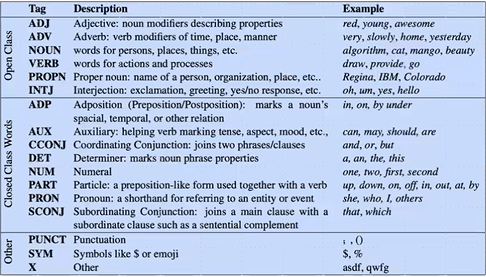

In [3]:
class BROWNDataset():
    def __init__(self,ratio_split=0.2):
        self.ratio_split=ratio_split
        self.train_sentences, self.test_sentences, self.train_tags, self.test_tags = self.load_data()
        self.word_vocab, self.words = self. build_vocabulary(self.train_sentences)
        self.tag_vocab, self.tags = self.build_vocabulary(self.train_tags)

    def load_data(self):
        brown_corpus=nltk.corpus.brown.tagged_sents(tagset='universal')

        sentences,tags=[],[]
        for pairs in brown_corpus:
            sent=[pair[0] for pair in pairs]
            tag=[pair[1] for pair in pairs]
            sentences.append(sent)
            tags.append(tag)

        return train_test_split(
                sentences, tags,
                test_size=self.ratio_split,
                random_state=11
        )

    def build_vocabulary(self,sentences):
        tokens=[]
        for sent in sentences:
            tokens.extend(sent)
        vocab=Counter(tokens)
        return dict(vocab), tokens


In [4]:
brown_dataset=BROWNDataset()

In [5]:
brown_dataset.tag_vocab

{'ADP': 115738,
 'PRON': 39546,
 'VERB': 145898,
 'ADJ': 66947,
 'NOUN': 220097,
 'CONJ': 30411,
 '.': 118022,
 'DET': 109385,
 'ADV': 44758,
 'PRT': 23870,
 'NUM': 11848,
 'X': 1135}

In [6]:
len(brown_dataset.word_vocab)

50497

In [7]:
brown_dataset.train_sentences[0],brown_dataset.train_tags[1]

(['Since',
  'he',
  'had',
  'gross',
  'income',
  'of',
  '$600',
  'or',
  'more',
  ',',
  'he',
  'must',
  'file',
  'a',
  'return',
  'in',
  'which',
  'he',
  'may',
  'claim',
  'an',
  'exemption',
  'deduction',
  'of',
  '$600',
  '.'],
 ['PRON',
  'VERB',
  'VERB',
  'ADP',
  'NOUN',
  'ADP',
  'DET',
  'NOUN',
  'CONJ',
  'DET',
  'NOUN',
  '.'])

# **BUILD AN HIDDEN MARKOV MODEL TAGGER**

Unigram count
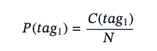

In [8]:
tag_unigram=brown_dataset.tag_vocab
tag_unigram #frequency of tag

{'ADP': 115738,
 'PRON': 39546,
 'VERB': 145898,
 'ADJ': 66947,
 'NOUN': 220097,
 'CONJ': 30411,
 '.': 118022,
 'DET': 109385,
 'ADV': 44758,
 'PRT': 23870,
 'NUM': 11848,
 'X': 1135}

Bigram count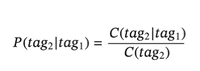

In [9]:
def bigram_count(sequences):
    bigram_count={}

    for i, sentence in enumerate(sequences):
        for j in range(len(sentence)-1): #exclude dot '.' at the end of the sentence
            if(sentence[j],sentence[j+1]) in bigram_count:
                bigram_count[(sentence[j],sentence[j+1])] +=1
            else:
                bigram_count[(sentence[j],sentence[j+1])] =1

    return bigram_count

tag_bigram=bigram_count(brown_dataset.train_tags)
tag_bigram #frequency of tags of 2

{('ADP', 'PRON'): 8148,
 ('PRON', 'VERB'): 27968,
 ('VERB', 'ADJ'): 8371,
 ('ADJ', 'NOUN'): 43633,
 ('NOUN', 'ADP'): 53822,
 ('ADP', 'NOUN'): 29843,
 ('NOUN', 'CONJ'): 13127,
 ('CONJ', 'ADJ'): 3416,
 ('ADJ', '.'): 6750,
 ('.', 'PRON'): 5472,
 ('VERB', 'VERB'): 26879,
 ('VERB', 'DET'): 23735,
 ('DET', 'NOUN'): 68512,
 ('ADP', 'DET'): 52783,
 ('DET', 'PRON'): 1085,
 ('NOUN', 'NOUN'): 32932,
 ('NOUN', '.'): 62511,
 ('VERB', 'ADP'): 24728,
 ('CONJ', 'DET'): 4599,
 ('NOUN', 'PRON'): 4381,
 ('ADP', 'ADJ'): 9590,
 ('.', 'NOUN'): 9863,
 ('NOUN', 'VERB'): 34835,
 ('ADJ', 'ADJ'): 3826,
 ('PRON', 'ADV'): 2132,
 ('ADV', 'VERB'): 10734,
 ('VERB', 'PRT'): 9579,
 ('PRT', 'DET'): 1995,
 ('NOUN', 'ADV'): 5805,
 ('ADV', 'PRT'): 1292,
 ('PRT', 'VERB'): 14864,
 ('DET', 'ADJ'): 26215,
 ('VERB', '.'): 11820,
 ('ADP', 'VERB'): 4704,
 ('VERB', 'NOUN'): 14220,
 ('CONJ', 'ADV'): 2762,
 ('ADV', 'PRON'): 2168,
 ('CONJ', 'VERB'): 5952,
 ('VERB', 'ADV'): 15048,
 ('ADV', 'ADP'): 6334,
 ('ADP', 'ADV'): 1771,
 ('ADV',

Sequence starting counts

In [10]:
def starting_counts(sequences):
    return (dict(Counter(i[0] for i in sequences)))

tag_starts=starting_counts(brown_dataset.train_tags) #frequency of a tag appear first in a sentence
tag_starts

{'ADP': 5661,
 'PRON': 7344,
 'CONJ': 2269,
 'DET': 9742,
 '.': 4085,
 'ADV': 4205,
 'NOUN': 6420,
 'PRT': 1688,
 'VERB': 2071,
 'NUM': 772,
 'ADJ': 1590,
 'X': 25}

Sequence ending counts

In [23]:
def ending_counts(sequences):
    return (dict(Counter(i[-1] for i in sequences)))

tag_ends=ending_counts(brown_dataset.train_tags)
tag_ends ##frequency of a tag end a sentence

{'.': 44930,
 'NOUN': 720,
 'NUM': 62,
 'VERB': 86,
 'DET': 13,
 'ADJ': 26,
 'ADP': 6,
 'ADV': 15,
 'PRT': 6,
 'PRON': 4,
 'CONJ': 2,
 'X': 2}

Pair counts

In [12]:
def pair_counts(tags,sequences):
    dct=defaultdict(dict)
    cnts=dict(Counter(list(zip(tags, sequences))))

    for k,v in cnts.items():
        dct[k[0]][k[1]]=v
    return dct
emission_counts=pair_counts(brown_dataset.tags,brown_dataset.words) #counts frequency of word with a tag

In [13]:
print(len(emission_counts)) #number of tags 12
emission_counts['NOUN']['time']

12


1249

BASIC - Hidden Markov Model

In [21]:
basic_model = HiddenMarkovModel(name='base-hmm-tagger')

add state to HMM

In [22]:
states={} #set of starting prob states

for tag in emission_counts:
    '''
    tag : ADP
    total tag appearance : 115738
    words with tag ADP's appearance : ([('Since', 141),
    ('of', 28831), ('in', 15217),
    ('with', 5630), ('In', 1472),
    ('for', 6989), ('through', 713), etc
    '''
    prob_dict={}
    total=tag_unigram[tag]
    prob_dict={key:value/total for key, value in emission_counts[tag].items()}

    tag_distribution=DiscreteDistribution(prob_dict)
    temp_state=State(tag_distribution,name=tag)
    states[tag]=temp_state

    basic_model.add_state(states[tag])

add starting sent,transition, ending sent prob

In [26]:
for bigram in tag_bigram.keys():
    len_data=len(brown_dataset.train_sentences)
    b0=bigram[0]
    b1=bigram[1]
    print(b0,b1)

    prob=tag_starts[b0]/len_data
    basic_model.add_transition(basic_model.start,states[b0],prob) #similair to starting prob states
    print(tag_starts[b0],prob)

    prob=tag_bigram[bigram]/tag_unigram[b0]
    basic_model.add_transition(states[b0],states[b1],prob)
    print(tag_bigram[bigram],tag_unigram[b0],prob)

    prob=tag_ends[b0]/len_data
    basic_model.add_transition(states[b0],basic_model.end,prob)
    print(tag_ends[b0],prob)
    print('============================================')

basic_model.bake()

ADP PRON
5661 0.12340861527729334
8148 115738 0.07040038708116608
6 0.0001307987443320544
PRON VERB
7344 0.16009766306243461
27968 39546 0.707227026753654
4 8.719916288803627e-05
VERB ADJ
2071 0.04514736658528078
8371 145898 0.05737570083208817
86 0.00187478200209278
ADJ NOUN
1590 0.03466166724799442
43633 66947 0.6517543728621148
26 0.0005667945587722358
NOUN ADP
6420 0.13995465643529822
53822 220097 0.24453763567881434
720 0.01569584931984653
ADP NOUN
5661 0.12340861527729334
29843 115738 0.25784962587914084
6 0.0001307987443320544
NOUN CONJ
6420 0.13995465643529822
13127 220097 0.059641885168811935
720 0.01569584931984653
CONJ ADJ
2269 0.049463725148238574
3416 30411 0.11232777613363586
2 4.359958144401814e-05
ADJ .
1590 0.03466166724799442
6750 66947 0.10082602655832225
26 0.0005667945587722358
. PRON
4085 0.08905214509940705
5472 118022 0.046364237176119705
44930 0.9794645971398674
VERB VERB
2071 0.04514736658528078
26879 145898 0.18423144936873706
86 0.00187478200209278
VERB DET


In [29]:
set(s.name for s in basic_model.states)

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X',
 'base-hmm-tagger-end',
 'base-hmm-tagger-start'}

# **PREDICTION**

In [32]:
def replace_unknown(sequence):
    return [word if word in brown_dataset.word_vocab else 'nan' for word in sequence]

def decoding(X,model):
    _,state_path=model.viterbi(replace_unknown(X)) #probability estimate of the most likely sequence of hidden states
    return [state[1].name for state in state_path[1:-1]] #path with largest path only

In [34]:
test=brown_dataset.test_sentences[0]
print('Testing example: ',test)

result=decoding(test,basic_model)
print('Testing result: ',result)

print('True tag: ',brown_dataset.test_tags[0])

Testing example:  ['Chauncey', 'Depew', ',', 'one-time', 'runner-up', 'for', 'the', 'Republican', 'Presidential', 'nomination', ',', 'was', 'attending', 'a', 'convention', 'at', 'Saratoga', ',', 'where', 'he', 'was', 'scheduled', 'to', 'nominate', 'Colonel', 'Theodore', 'Roosevelt', 'for', 'Governor', 'of', 'New', 'York', 'when', 'he', 'noticed', 'that', 'the', 'temporary', 'chairman', 'was', 'a', 'man', 'he', 'had', 'never', 'met', '.']
Testing result:  ['NOUN', 'NOUN', '.', 'NOUN', 'NOUN', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', 'ADV', 'PRON', 'VERB', 'VERB', 'PRT', 'VERB', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'ADV', 'PRON', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'VERB', 'DET', 'NOUN', 'PRON', 'VERB', 'ADV', 'VERB', '.']
True tag:  ['NOUN', 'NOUN', '.', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', 'ADV', 'PRON', 'VERB', 'VERB', 'PRT', 'VERB', 'NOUN',

# **EVALUATION**

In [35]:
def compute_acc(sentences,tags,model):
    correct_pred=total_pred=0
    for sent,tag in zip(sentences,tags):
        try:
            pred_tags=decoding(sent,model)
            correct_pred+=sum(pred==true_tag for pred,true_tag in zip(pred_tags,tag))
        except:
            pass
        total_pred+=len(sent)
    return correct_pred/total_pred

In [36]:
acc=compute_acc(brown_dataset.test_sentences,brown_dataset.test_tags,basic_model)
acc

0.959663779187024